In [27]:
%matplotlib inline
import pylab as plt
from blimpy import Waterfall
import numpy as np
from scipy import interpolate
import peakutils
import rfi
import turbo_seti
import pandas as pd
import BaselineRemoval
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import scipy

In [12]:
gps="data/20200917_guppi_59143_55142_000486_GPS-BIIR-11_0001-ics.rawspec.combined.fil"
w=Waterfall(gps)
wf=Waterfall("data/20200917_guppi_59074_56719_004562_J0835-4510_0001-ics.rawspec.0000.combined.fil")
f1=w.get_freqs()
f2=wf.get_freqs()
power1=w.get_power()[1]
power2=wf.get_power()[1]

extracting integration 0...
extracting integration 0...


First, use a BaselineRemoval module to remove baseline. Note that it is not a perfect fit. Further fitting required

In [58]:
power1.mean()/power1.std()

0.38016328

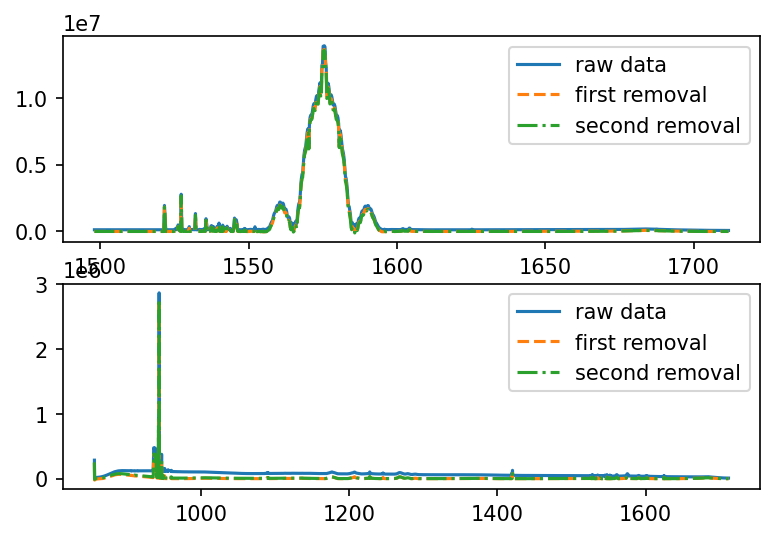

In [13]:
plt.figure(dpi=150)
t_1=BaselineRemoval.BaselineRemoval(power1)
t_2=BaselineRemoval.BaselineRemoval(power2)
n_1=t_1.ZhangFit()
n1=BaselineRemoval.BaselineRemoval(n_1).ZhangFit()
n_2=t_2.ZhangFit()
n2=BaselineRemoval.BaselineRemoval(n_2).ZhangFit()
plt.subplot(2,1,1)
plt.plot(f1,power1,label="raw data")
plt.plot(f1,n_1,'--',label="first removal")
plt.plot(f1,n1,'-.',label='second removal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(f2,power2,label="raw data")
plt.plot(f2,n_2,'--',label="first removal")
plt.plot(f2,n2,'-.',label='second removal')
# plt.ylim(0,0.5e6)
# plt.xlim(1000,1100)
plt.legend()
plt.show()

Now, two different to improve the baseline fitting

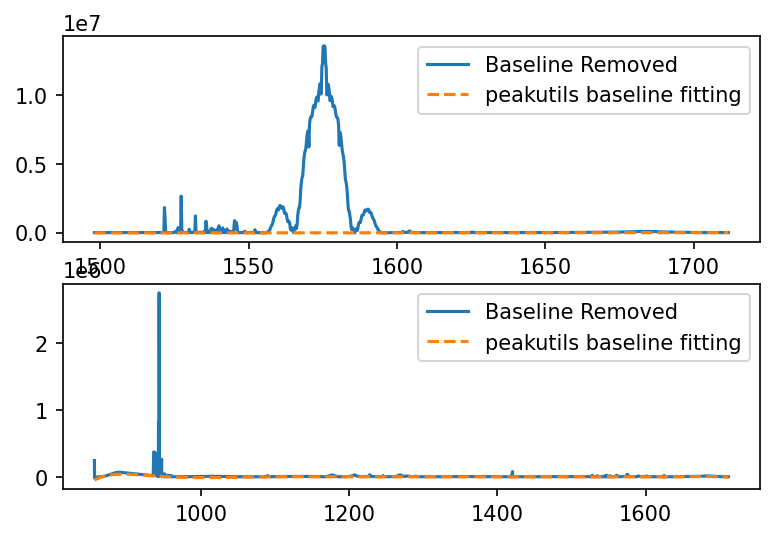

In [57]:
#Peakutils
plt.figure(dpi=150)
base_1=peakutils.baseline(n_1,deg=1)
base_2=peakutils.baseline(n_2,deg=10)
plt.subplot(2,1,1)
plt.plot(f1,n_1,label='Baseline Removed')
plt.plot(f1,base_1,'--',label='peakutils baseline fitting')
plt.legend()
plt.subplot(2,1,2)
plt.plot(f2,n_2,label='Baseline Removed')
plt.plot(f2,base_2,'--',label='peakutils baseline fitting')
plt.legend()
plt.show()

In [15]:
np.where(n_1-base_1<0)

(array([272, 274, 275, 420, 464, 465, 466, 467, 469, 472, 473]),)

In [45]:
npower=np.where(n_1-base_1<0,0,n_1-base_1)
thres=np.amax(npower)/60

In [46]:
intercept=[]
for i in range(len(npower)-1):
    if npower[i]==thres:
        intercept.append(f1[i])
    elif (npower[i]-thres)*(npower[i+1]-thres)<0:
        x_i=(thres-npower[i])*(f1[i+1]-f1[i])/(npower[i+1]-npower[i])+f1[i]
        intercept.append(x_i)
i=0
test=[]
dist=20
while i<len(intercept)-1:
    start=intercept[i]
    if(intercept[i+1]-start<=dist):
        end=intercept[i+1]
        length=len(intercept[i+1:])
        for j in range(length):
            if j==length-1:
                end=intercept[i+1:][j]
                i+=j+1
                test.append([start,end])
                break
            else:
                if (abs(intercept[i+1:][j]-end)<=dist):
                    end=intercept[i+1:][j]
                else:
                    i+=j+1
                    if(j==0):
                        test.append([start,start])
                    else:
                        test.append([start,end])
                    break
    else:
        test.append([start,start])
        i+=1
test

[[1521.42962638467, 1593.6080196182818]]

In [48]:
rfi.rfi(npower,div=100)

wrong file type


extracting integration 0...
extracting integration 0...


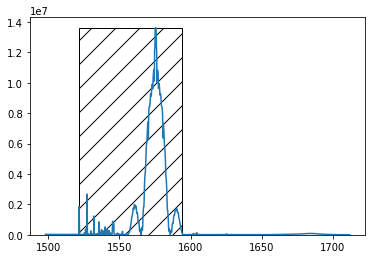

In [54]:
plt.plot(f1,npower)
test=rfi.rfi(w,div=70,dist=25)
for i in test:
    plt.bar((i[0]+i[1])/2,np.amax(npower),width=i[1]-i[0],bottom=0.0,edgecolor='black',hatch='/',color='w')
#plt.xlim(1520,1550)

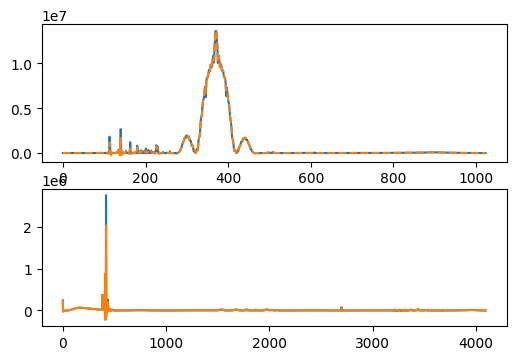

In [19]:
#spline fitting
plt.figure(dpi=100)
#For the first waterfall
plt.subplot(2,1,1)
num=w.container.n_channels_in_file
x=np.arange(num)
spl_order=num
knots = np.arange(0,num,num//spl_order+1)
spl = interpolate.splrep(x, n_1, t=knots[1:])
chan_fit = interpolate.splev(x, spl)
plt.plot(x,n_1,label="Removed baseline")
plt.plot(x,chan_fit,'--',label='spline fitting')
# plt.xlim(400,400.25)
# plt.ylim(0.e7,0.59e7)
#For the second waterfall
plt.subplot(2,1,2)
num=wf.container.n_channels_in_file
x=np.arange(num)
spl_order=num
knots = np.arange(0,num,num//spl_order+1)
spl = interpolate.splrep(x, n_2, t=knots[1:])
chan_fit = interpolate.splev(x, spl)
plt.plot(x,n_2)
plt.plot(x,chan_fit)
#plt.xlim(400,500)

In conclusion, spline fitting is great for signals with high SNR like [here](https://github.com/FX196/SETI-Energy-Detection#bandpass-removal), whereas peakutils can be used either high or low SNR but with lower accuracy. NOTE that, in order to make to fitting better, a "[BaselineRemoval](https://pypi.org/project/BaselineRemoval/)" module was used. Even thought this module create a baseline fit as well, peakutils should still be implemented to improve the accuracy.